In [1]:
"""
File Created: 2023-12-06
Author: Patrick G. Cho
Contact: pcho@nd.edu
Purpose: Significant Correlation Analysis of d18O_P on different timescales

Details:
This script is designed to illustrate the spatio-temporal relationship between the IWC and PWC metrics and the d18O_P fields in ECHAM5-wiso. The analysis encompasses various timescales the east African Short Rains (October, November, December), as well as Annual, Three-Year, and Five-Year intervals. Additionally, we employ multiple regression to analyze the extent to which the Walker Circulation influences water isotopes on different timescales. The script achieves this by downsampling the time series data into the specified intervals. The study period spans from 1958 to 2013. 

In summary, this notebook will produce the foundational figures for Figure 2 and Figure S2. It also has the multivariate analysis that is shown in Table S1. 
"""

'\nFile Created: 2023-12-06\nAuthor: Patrick G. Cho\nContact: pcho@nd.edu\nPurpose: Significant Correlation Analysis of d18O_P on different timescales\n\nDetails:\nThis script is designed to illustrate the spatio-temporal relationship between the IWC and PWC metrics and the d18O_P fields in ECHAM5-wiso. The analysis encompasses various timescales the east African Short Rains (October, November, December), as well as Annual, Three-Year, and Five-Year intervals. Additionally, we employ multiple regression to analyze the extent to which the Walker Circulation influences water isotopes on different timescales. The script achieves this by downsampling the time series data into the specified intervals. The study period spans from 1958 to 2013.\n'

# Load Packages

In [1]:
# Data Management
import pandas as pd
import xarray as xr
import dask.array as dask
import cftime

# Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Correlation Analysis
import numpy as np
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm

# Calculations
from amount_weighted_ann_mean import amount_weighted_ann_mean
from weighted_temporal_mean import weighted_temporal_mean
from spatial_corr import compute_correlations

# Image Resolution on MacOS
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Clean Data

In [2]:
path = '/Users/cpatrickfly/Library/CloudStorage/GoogleDrive-pcho@nd.edu/Shared drives/PhD Research/IWC Precipitation Isotopes/02_RawData/'
path2 = '/Users/cpatrickfly/Library/CloudStorage/GoogleDrive-pcho@nd.edu/Shared drives/PhD Research/IWC Precipitation Isotopes/03_ProcessedData/'

In [3]:
# Load Metrics; Study period 1958 to 2013
metricsMon            = pd.read_csv(path2+'240220_PC_IWCMetrics.csv')
metricsMon['time']    = pd.to_datetime(metricsMon['time'])
metricsMon            = metricsMon.set_index('time')['1957-12-16' : '2013-12-16'] 

ond = metricsMon[metricsMon.index.month.isin([10, 11, 12])].resample('Y').mean() # OND Averages of Every Year

metrics               = pd.read_csv(path2+'240304_PC_IWCMetricsAnn.csv')
metrics['time']       = pd.to_datetime(metrics['time'])
metrics               = metrics.set_index('time')['1958-12-16':'2014-12-16'] 

# ECHAM; 1958-2013
echam                 = xr.open_dataset(path2+'240304_PC_ECHAMFULL.nc')
IOB                   = xr.open_dataset(path2+'240304_PC_ECHAM_IOB.nc')

In [4]:
# Compute Amount-Weighted Annual Means
isotopes = amount_weighted_ann_mean(IOB,'precip',['d18O_P'])
isotopes['precip'] = weighted_temporal_mean(IOB,'precip')
isotopes = isotopes - isotopes.mean(dim='time')

# OND
OND = IOB[['d18O_P']].sel(time=(IOB.time.dt.month >= 10) & (IOB.time.dt.month <= 12)).resample(time='Y').mean()
OND = OND.groupby('time.month') - OND.groupby('time.month').mean(dim='time')

# Calculate different temporal aggregations
roll3 = isotopes.resample(time = '3Y').mean()
roll10 = isotopes.resample(time = '10Y').mean()

roll3o = OND.resample(time = '3Y').mean()
roll10o = OND.resample(time = '10Y').mean()

metrics3 = metrics.resample('3Y').mean()
metrics10 = metrics.resample('10Y').mean()

ond3 = ond.resample('3Y').mean()
ond10 = ond.resample('10Y').mean()

# Spatial Analysis

## Computes Spatial  Correlations; OND Region vs OND Metrics

In [5]:
# OND Correlation Maps
cor_mapOWSR, cor_mapOWpSR = compute_correlations(OND, ond, 'u10', IOB)
cor_mapOSLPSR, cor_mapOSLPpSR = compute_correlations(OND, ond, 'dSLP', IOB)
cor_mapPWCSR, cor_mapPWCpSR = compute_correlations(OND, ond, 'dSLPP', IOB)

# Amount-Weighted Annual Means
cor_mapOW, cor_mapOWp = compute_correlations(isotopes, metrics, 'u10', IOB)
cor_mapOSLP, cor_mapOSLPp = compute_correlations(isotopes, metrics, 'dSLP', IOB)
cor_mapPWC, cor_mapPWCp = compute_correlations(isotopes, metrics, 'dSLPP', IOB)

# 3 and 10 Year Averages from Precipitation Amount-Weighted Annual Means; This is a work around for individual coherence from frequency.
cor_mapOW3, cor_mapOWp3 = compute_correlations(roll3, metrics3, 'u10', IOB)
cor_mapOSLP3, cor_mapOSLPp3 = compute_correlations(roll3, metrics3, 'dSLP', IOB)
cor_mapPWC3, cor_mapPWCp3 = compute_correlations(roll3, metrics3, 'dSLPP', IOB)

cor_mapOW10, cor_mapOWp10 = compute_correlations(roll10, metrics10, 'u10', IOB)
cor_mapOSLP10, cor_mapOSLPp10 = compute_correlations(roll10, metrics10, 'dSLP', IOB)
cor_mapPWC10, cor_mapPWCp10 = compute_correlations(roll10, metrics10, 'dSLPP', IOB)

# Rolling Windows for OND; Computes Correlation Coefficient for different Rolling Means; A work around frequencies
cor_mapOW3o, cor_mapOWp3o = compute_correlations(roll3o, ond3, 'u10', IOB)
cor_mapOSLP3o, cor_mapOSLPp3o = compute_correlations(roll3o, ond3, 'dSLP', IOB)
cor_mapPWC3o, cor_mapPWCp3o = compute_correlations(roll3o, ond3, 'dSLPP', IOB)

cor_mapOW10o, cor_mapOWp10o = compute_correlations(roll10o, ond10, 'u10', IOB)
cor_mapOSLP10o, cor_mapOSLPp10o = compute_correlations(roll10o, ond10, 'dSLP', IOB)
cor_mapPWC10o, cor_mapPWCp10o = compute_correlations(roll10o, ond10, 'dSLPP', IOB)

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [6]:
# Amount-Weighted Annual Means Maps for PWC
cor_mapPWC, cor_mapPWCp = compute_correlations(isotopes, metrics, 'dSLPP', IOB)
cor_mapPWC3, cor_mapPWCp3 = compute_correlations(roll3, metrics3, 'dSLPP', IOB)
cor_mapPWC10, cor_mapPWCp10 = compute_correlations(roll10, metrics10, 'dSLPP', IOB)

## Figure 2 OND Regions and OND Metrics

/var/folders/2k/2vgl0pwd6gnfr1h_2nrk8p8c0000gn/T/ipykernel_57763/273897261.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


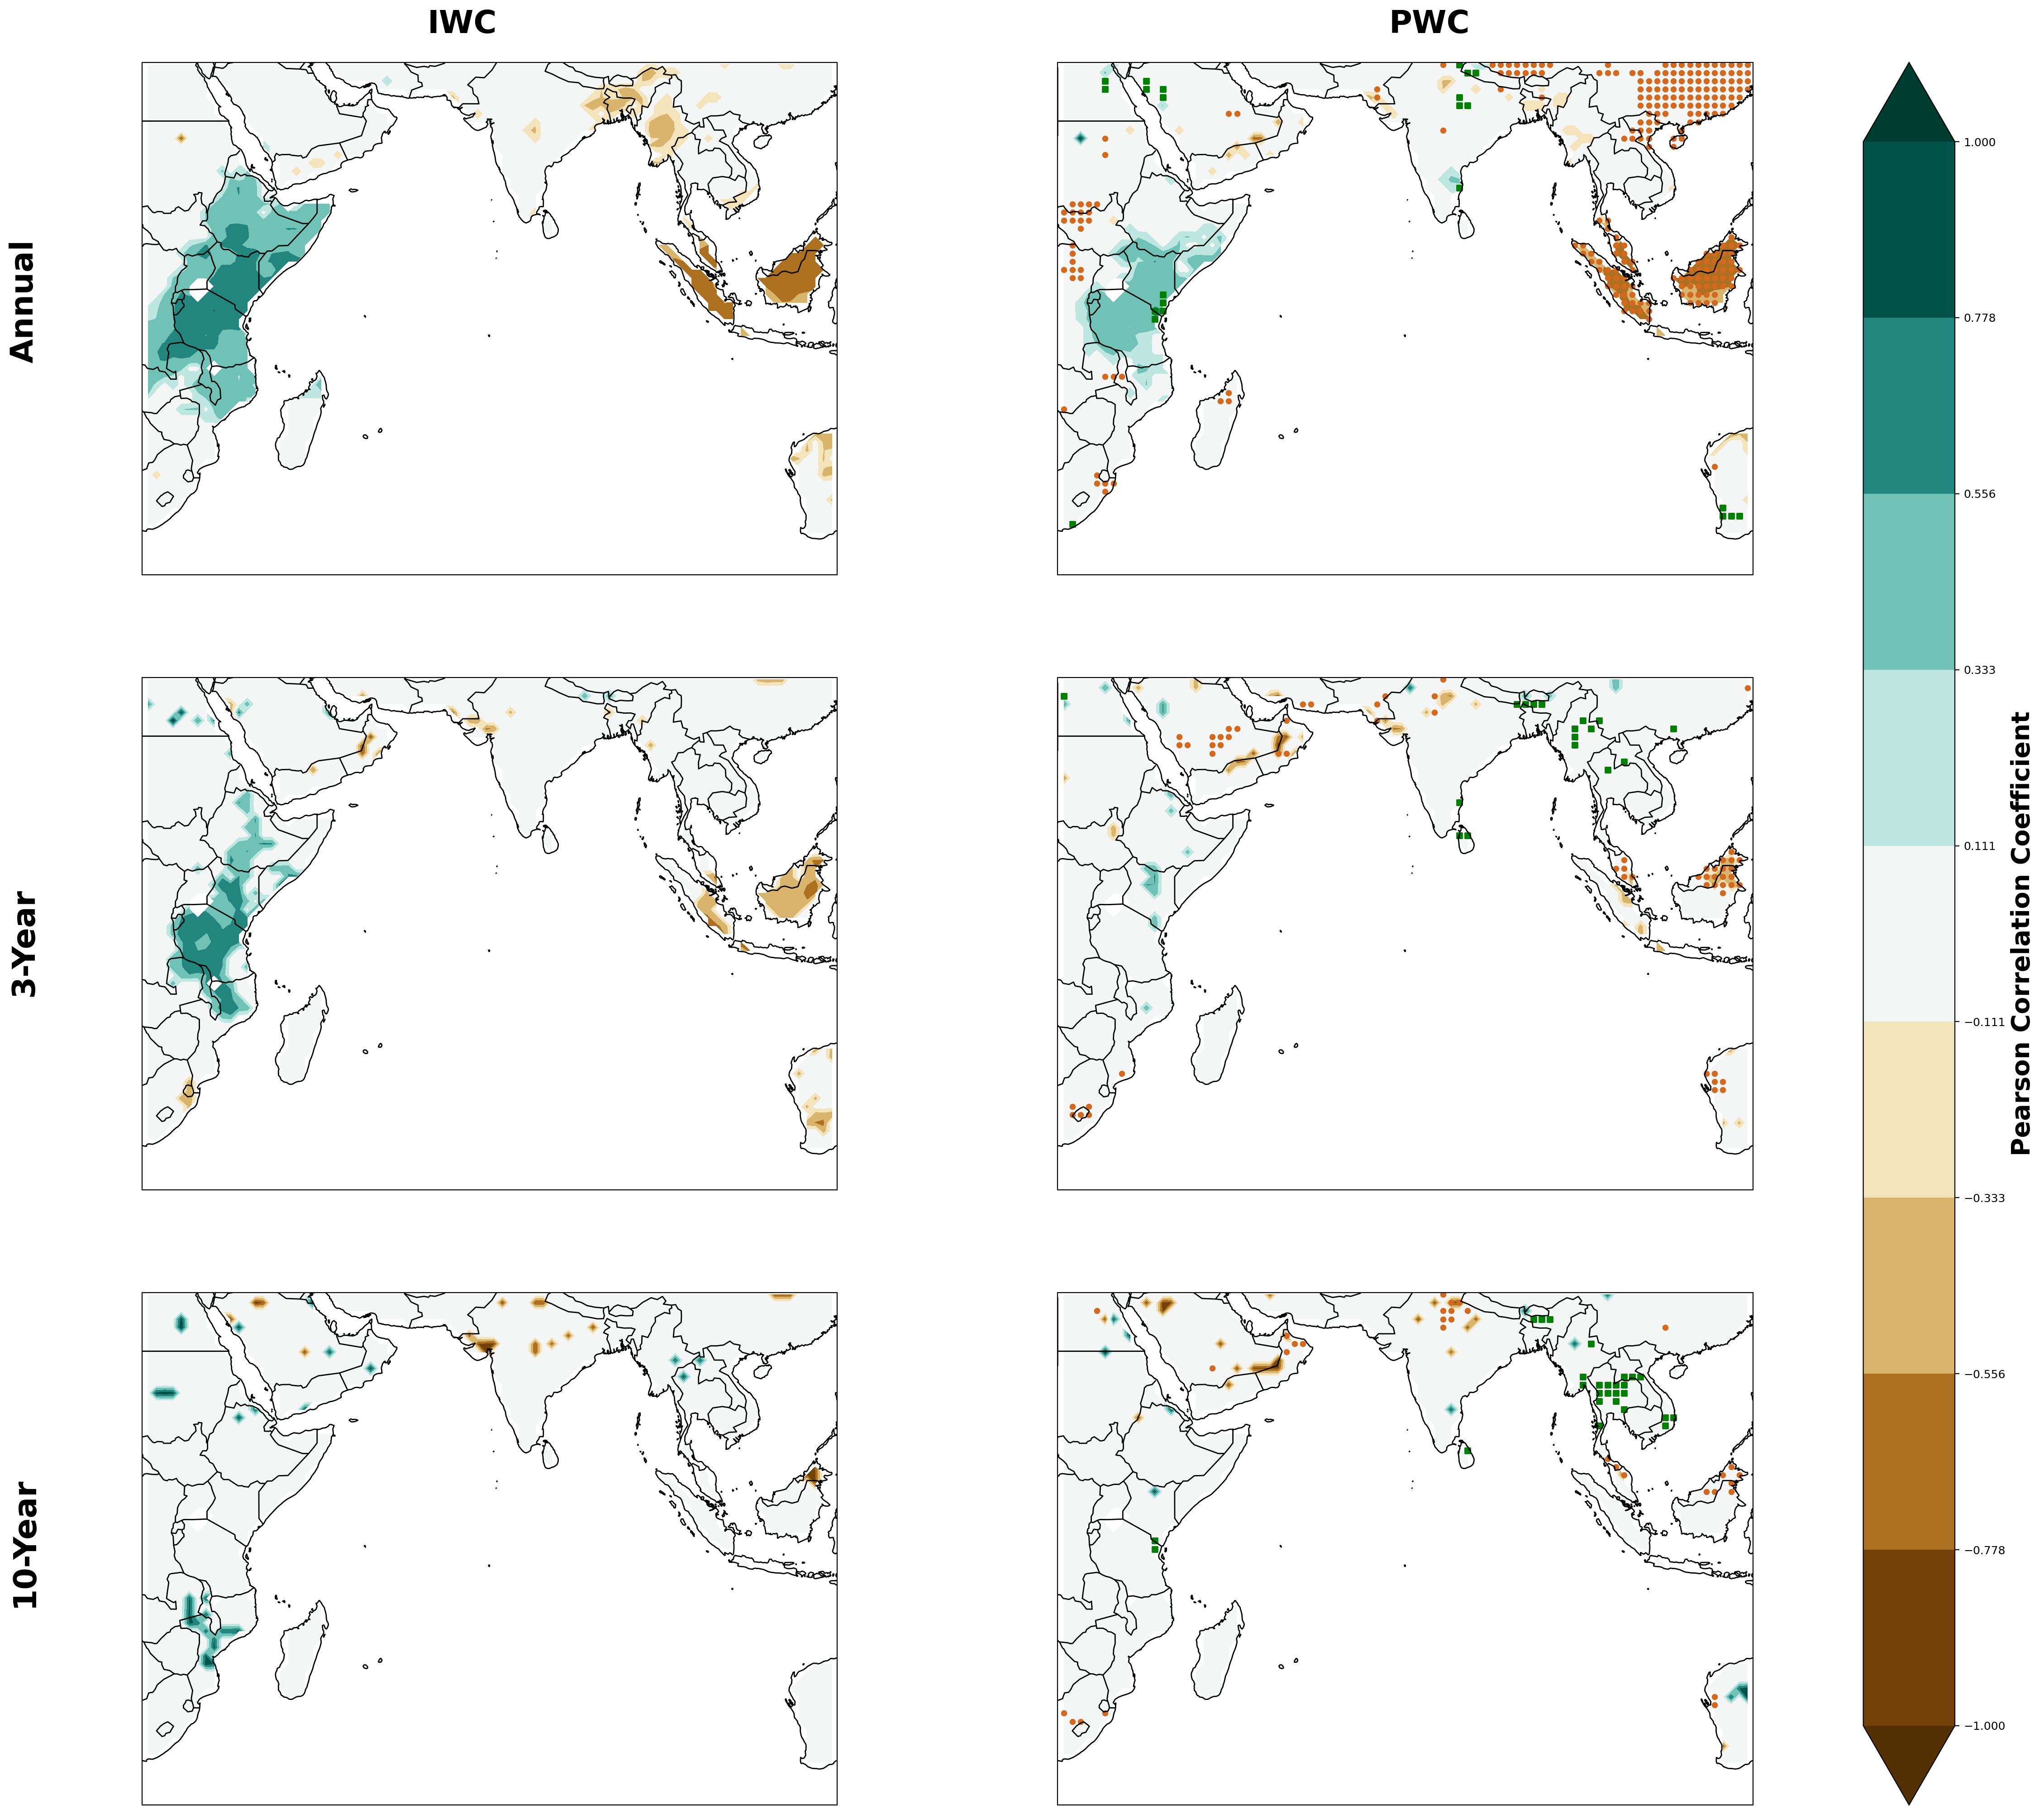

In [16]:
# Spatial Correlation with Colored Contours and IWC and PWC for each Column; Both Columns are OND
fig = plt.figure(figsize=(25,25))
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1,1,1], width_ratios=[1,1,0.1], figure=fig)
gs.update(left=0.1, right=0.95, wspace=0, hspace=0.2)

levels = np.linspace(-1, 1, 10)
extent = [25, 120, -40, 30]

legend_elements = [Line2D([0], [0], color='black', linestyle='solid', linewidth=2, label='PWC Positive Correlation'),
                   Line2D([0], [0], color='black', linestyle='dashed', linewidth=2, label='PWC Negative Correlation')]

# IWC; OND Annual
ax1 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=0))
cont1 = ax1.contourf(cor_mapOWSR.Longitude, cor_mapOWSR.Latitude, cor_mapOWSR.values, levels=levels, extend='both', cmap='BrBG')
ax1.set_extent(extent, ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.BORDERS)

# PWC; OND Annual with solid for positive, dashed for negative
ax2 = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=0))
cont2 = ax2.contourf(cor_mapPWCSR.Longitude, cor_mapPWCSR.Latitude, cor_mapPWCSR.values, levels=levels, extend='both', cmap='BrBG')
significant_indices = np.where(cor_mapPWC.values < 0)  # Replace this with your significance condition
positive_indices = np.where(cor_mapPWC.values > 0)
ax2.scatter(cor_mapPWC.Longitude[positive_indices[1]], cor_mapPWC.Latitude[positive_indices[0]], 
            color='green', s=20, marker='s', label='Positive Correlation')
negative_indices = np.where(cor_mapPWC.values < 0)
ax2.scatter(cor_mapPWC.Longitude[negative_indices[1]], cor_mapPWC.Latitude[negative_indices[0]], 
            color='chocolate', s=15, marker='o', label='Negative Correlation')
ax2.set_extent(extent, ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.BORDERS)

# IWC; OND 3-Year
ax3 = fig.add_subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=0))
cont3 = ax3.contourf(cor_mapOW3o.Longitude, cor_mapOW3o.Latitude, cor_mapOW3o.values, levels=levels, extend='both', cmap='BrBG')
ax3.set_extent(extent, ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax3.add_feature(cfeature.BORDERS)

ax4 = fig.add_subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=0))
cont4 = ax4.contourf(cor_mapPWC3o.Longitude, cor_mapPWC3o.Latitude, cor_mapPWC3o.values, levels=levels, extend='both', cmap='BrBG')
positive_indices3 = np.where(cor_mapPWC3.values > 0)
ax4.scatter(cor_mapPWC3.Longitude[positive_indices3[1]], cor_mapPWC3.Latitude[positive_indices3[0]], 
            color='green', s=20, marker='s', label='Positive Correlation')
negative_indices3 = np.where(cor_mapPWC3.values < 0)
ax4.scatter(cor_mapPWC3.Longitude[negative_indices3[1]], cor_mapPWC3.Latitude[negative_indices3[0]], 
            color='chocolate', s=15, marker='o', label='Negative Correlation')
ax4.set_extent(extent, ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax4.add_feature(cfeature.BORDERS)

# IWC; OND 10-Year
ax5 = fig.add_subplot(gs[2,0], projection=ccrs.PlateCarree(central_longitude=0))
cont5 = ax5.contourf(cor_mapOW10o.Longitude, cor_mapOW10o.Latitude, cor_mapOW10o.values, levels=levels, extend='both', cmap='BrBG')
ax5.set_extent(extent, ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax5.add_feature(cfeature.BORDERS)

# PWC; OND 10-Year with solid for positive, dashed for negative
ax6 = fig.add_subplot(gs[2,1], projection=ccrs.PlateCarree(central_longitude=0))
cont6 = ax6.contourf(cor_mapPWC10o.Longitude, cor_mapPWC10o.Latitude, cor_mapPWC10o.values, levels=levels, extend='both', cmap='BrBG')
positive_indices10 = np.where(cor_mapPWC10.values > 0)
ax6.scatter(cor_mapPWC10.Longitude[positive_indices10[1]], cor_mapPWC10.Latitude[positive_indices10[0]], 
            color='green', s=20, marker='s', label='Positive Correlation')
negative_indices10 = np.where(cor_mapPWC10.values < 0)
ax6.scatter(cor_mapPWC10.Longitude[negative_indices10[1]], cor_mapPWC10.Latitude[negative_indices10[0]], 
            color='chocolate', s=15, marker='o', label='Negative Correlation')
ax6.set_extent(extent, ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax6.add_feature(cfeature.BORDERS)

# Adding annotations
fig.text(0.275, 0.893, 'IWC', fontsize=25, fontweight='bold', color='k')
fig.text(0.7, 0.893, 'PWC', fontsize=25, fontweight='bold', color='k')
fig.text(0.09, 0.75, 'Annual', fontsize=25, fontweight='bold', rotation=90, color='k')
fig.text(0.09, 0.47, '3-Year', fontsize=25, fontweight='bold', rotation=90, color='k')
fig.text(0.09, 0.2, '10-Year', fontsize=25, fontweight='bold', rotation=90, color='k')

# Adding color bar
ax7 = fig.add_subplot(gs[:,2])
cbar = plt.colorbar(cont1, cax=ax7, orientation='vertical') 
cbar.ax.tick_params(labelsize=9)
cbar.set_label('Pearson Correlation Coefficient', fontsize=20, fontweight='bold')

plt.tight_layout()
#plt.savefig('/Users/cpatrickfly/Library/CloudStorage/GoogleDrive-pcho@nd.edu/Shared drives/PhD Research/IWC Precipitation Isotopes/04_Outputs/241112_PWC_Spatial_ERA5_OND.pdf',bbox_inches='tight',dpi=600)

## Computes Spatial  Correlations; OND Region vs Annual Metrics

In [7]:
# OND Correlation Maps
cor_mapOWSR, cor_mapOWpSR = compute_correlations(OND, metrics, 'u10', IOB)
cor_mapOSLPSR, cor_mapOSLPpSR = compute_correlations(OND, metrics, 'dSLP', IOB)
cor_mapPWCSR, cor_mapPWCpSR = compute_correlations(OND, metrics, 'dSLPP', IOB)

# Amount-Weighted Annual Means
cor_mapOW, cor_mapOWp = compute_correlations(isotopes, metrics, 'u10', IOB)
cor_mapOSLP, cor_mapOSLPp = compute_correlations(isotopes, metrics, 'dSLP', IOB)
cor_mapPWC, cor_mapPWCp = compute_correlations(isotopes, metrics, 'dSLPP', IOB)

# 3 and 10 Year Averages from Precipitation Amount-Weighted Annual Means; This is a work around for individual coherence from frequency.
cor_mapOW3, cor_mapOWp3 = compute_correlations(roll3, metrics3, 'u10', IOB)
cor_mapOSLP3, cor_mapOSLPp3 = compute_correlations(roll3, metrics3, 'dSLP', IOB)
cor_mapPWC3, cor_mapPWCp3 = compute_correlations(roll3, metrics3, 'dSLPP', IOB)

cor_mapOW10, cor_mapOWp10 = compute_correlations(roll10, metrics10, 'u10', IOB)
cor_mapOSLP10, cor_mapOSLPp10 = compute_correlations(roll10, metrics10, 'dSLP', IOB)
cor_mapPWC10, cor_mapPWCp10 = compute_correlations(roll10, metrics10, 'dSLPP', IOB)

# Rolling Windows for OND; Computes Correlation Coefficient for different Rolling Means; A work around frequencies
cor_mapOW3o, cor_mapOWp3o = compute_correlations(roll3o, metrics3, 'u10', IOB)
cor_mapOSLP3o, cor_mapOSLPp3o = compute_correlations(roll3o, metrics3, 'dSLP', IOB)
cor_mapPWC3o, cor_mapPWCp3o = compute_correlations(roll3o, metrics3, 'dSLPP', IOB)

cor_mapOW10o, cor_mapOWp10o = compute_correlations(roll10o, metrics10, 'u10', IOB)
cor_mapOSLP10o, cor_mapOSLPp10o = compute_correlations(roll10o, metrics10, 'dSLP', IOB)
cor_mapPWC10o, cor_mapPWCp10o = compute_correlations(roll10o, metrics10, 'dSLPP', IOB)

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


## Supplementary Figure for OND d18OP and Annual Metric

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'extedn'
  result = super().contourf(*args, **kwargs)
/var/folders/2k/2vgl0pwd6gnfr1h_2nrk8p8c0000gn/T/ipykernel_96746/3394344910.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


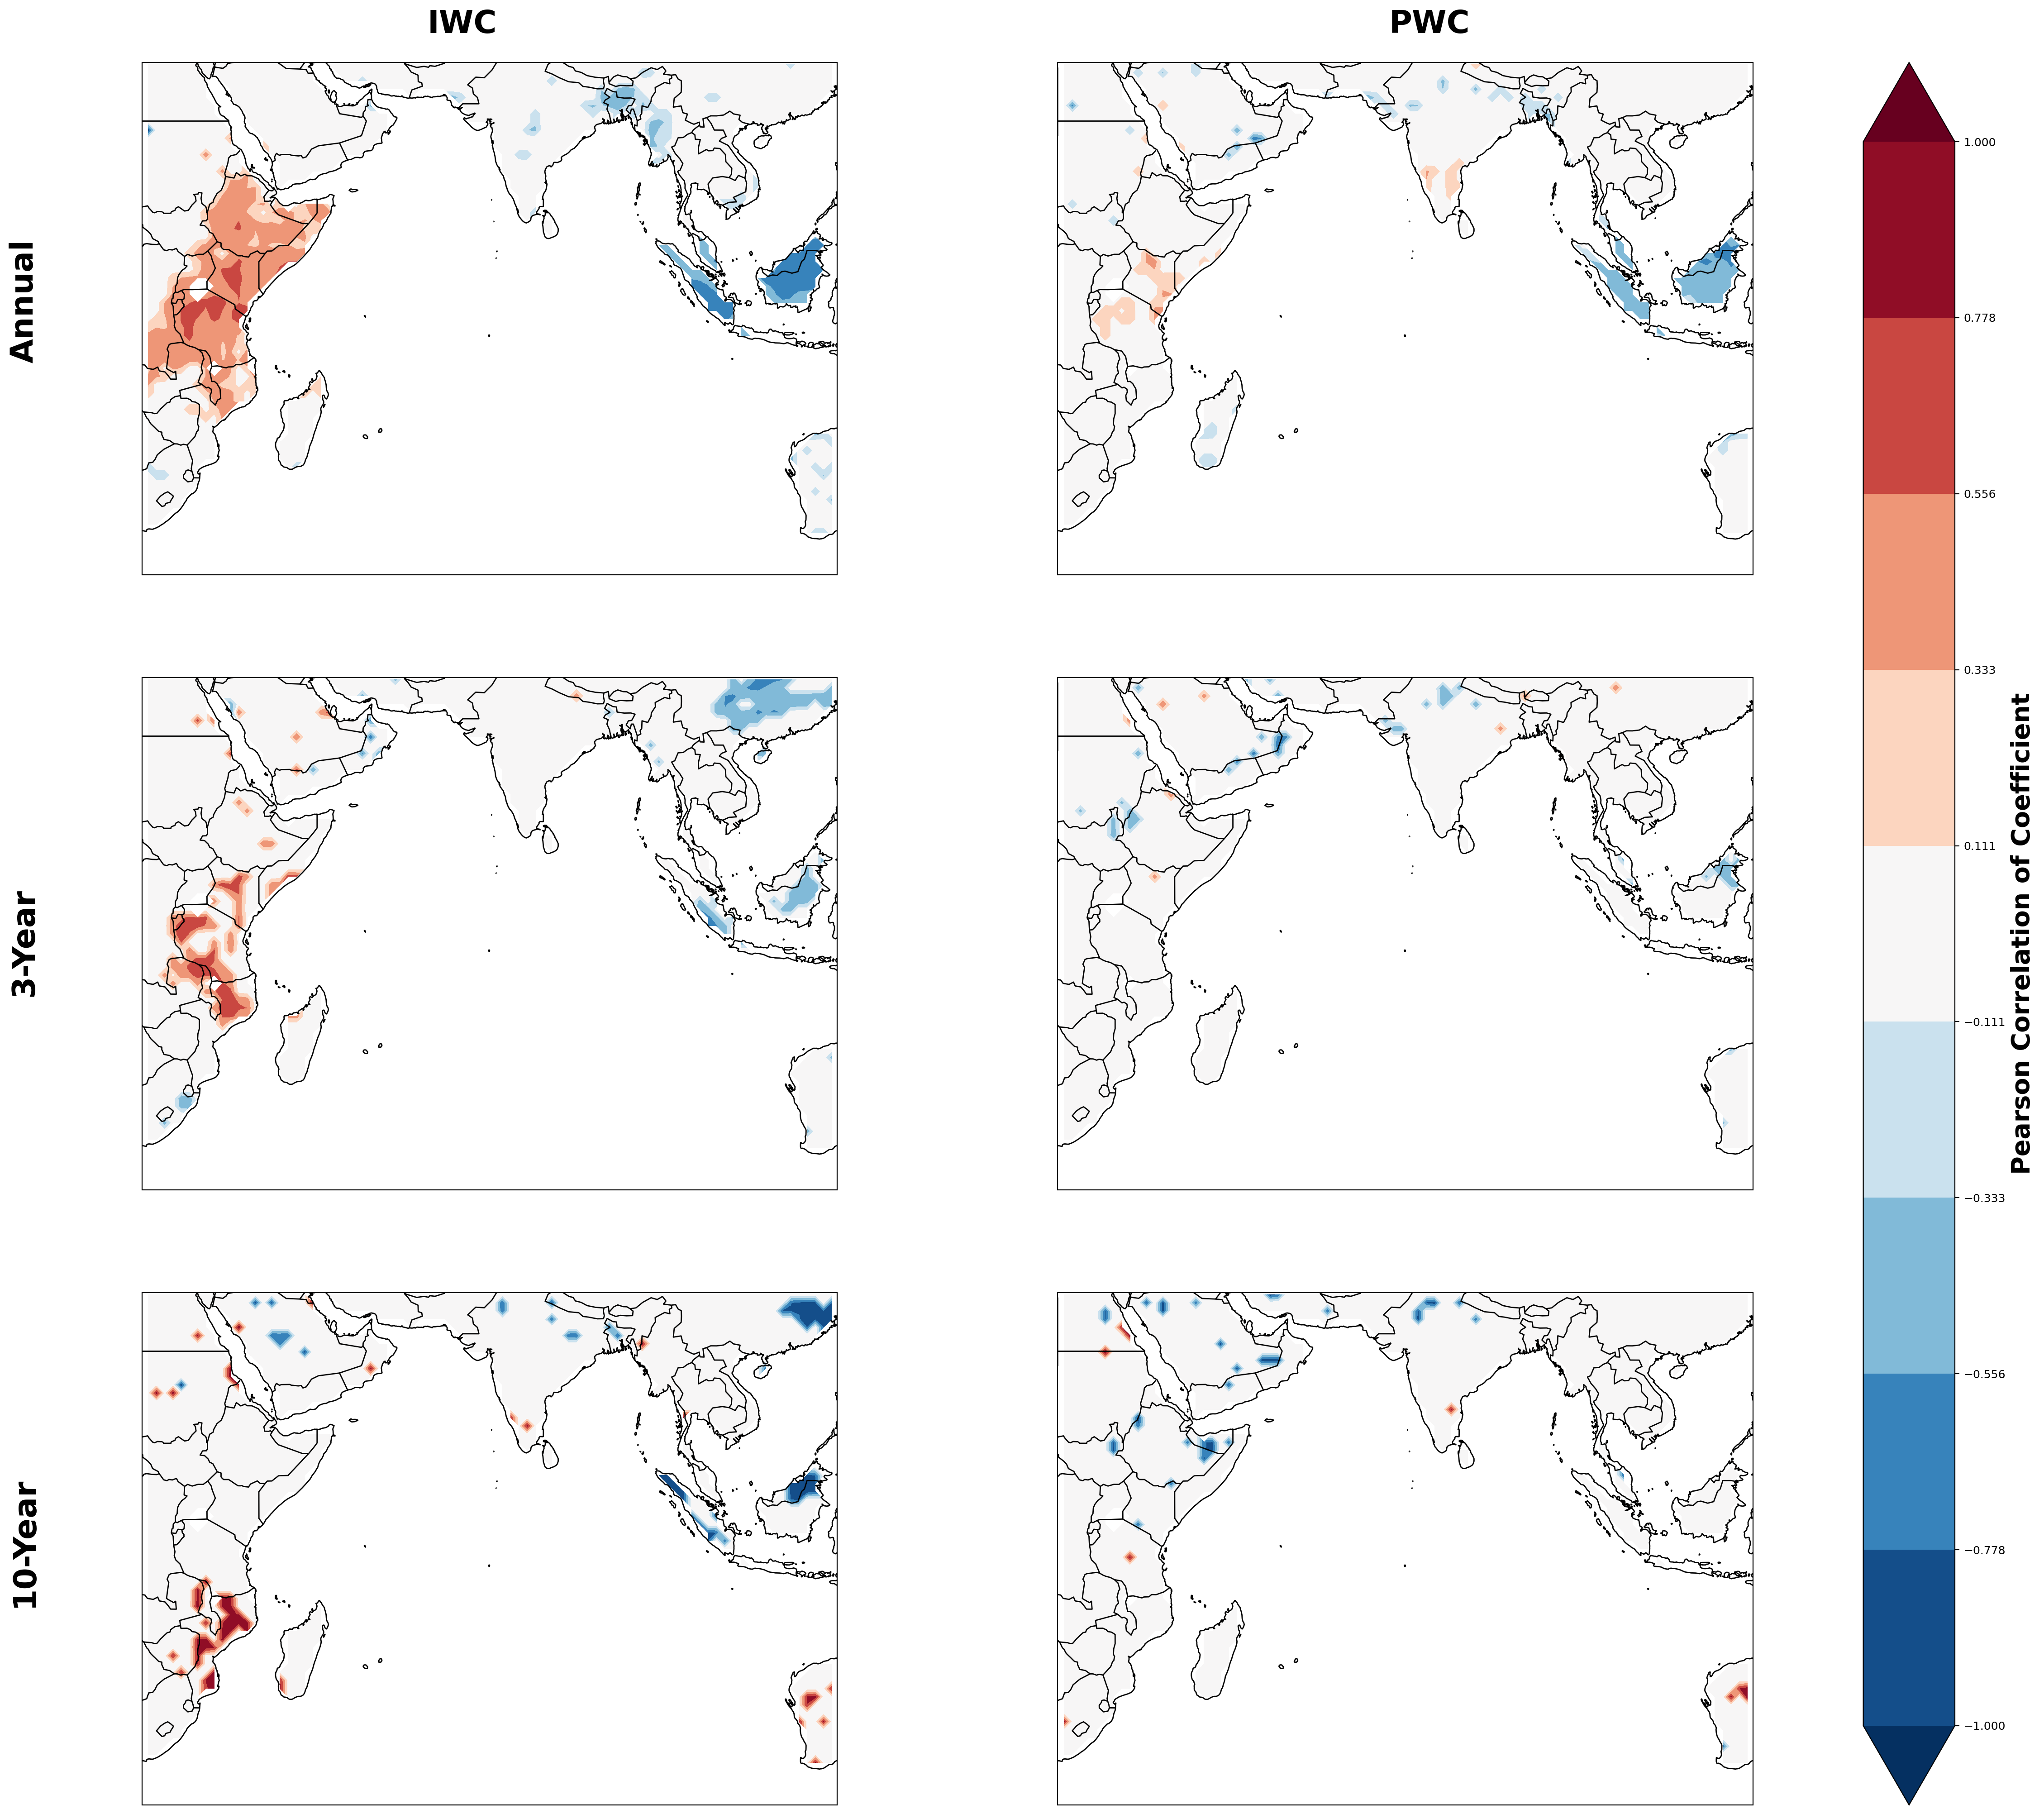

In [31]:
# Spatial Correlation with Colored Contours and IWC and PWC for each Column; Both Columns are OND
fig = plt.figure(figsize=(25,25))
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1,1,1], width_ratios=[1,1,0.1], figure=fig)
gs.update(left=0.1, right=0.95, wspace = 0, hspace=0.2)

levels = np.linspace(-1, 1, 10)
extent = [25, 120, -40, 30]

# IWC; OND Annual
ax1 = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=0))
cont1 = ax1.contourf(cor_mapOWSR.Longitude, cor_mapOWSR.Latitude, cor_mapOWSR.values, levels=levels, extend='both', cmap='RdBu_r')
ax1.set_extent(extent, ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.BORDERS)

# PWC; OND Annual 
ax2 = fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=0))
cont2 = ax2.contourf(cor_mapPWCSR.Longitude, cor_mapPWCSR.Latitude, cor_mapPWCSR.values, levels=levels, extedn='both', cmap='RdBu_r')
ax2.set_extent(extent, ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.BORDERS)

# IWC; OND 3-Year
ax3 = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree(central_longitude=0))
cont3 = ax3.contourf(cor_mapOW3o.Longitude, cor_mapOW3o.Latitude, cor_mapOW3o.values, levels=levels, extend='both', cmap='RdBu_r')
ax3.set_extent(extent, ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax3.add_feature(cfeature.BORDERS)

# PWC; OND 3-Year
ax4 = fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree(central_longitude=0))
cont4 = ax4.contourf(cor_mapPWC3o.Longitude, cor_mapPWC3o.Latitude, cor_mapPWC3o.values, levels=levels, extend='both',cmap='RdBu_r')
ax4.set_extent(extent, ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax4.add_feature(cfeature.BORDERS)

# IWC; OND 10-Year
ax5 = fig.add_subplot(gs[2,0],projection=ccrs.PlateCarree(central_longitude=0))
cont5 = ax5.contourf(cor_mapOW10o.Longitude, cor_mapOW10o.Latitude, cor_mapOW10o.values, levels=levels, extend='both', cmap='RdBu_r')
ax5.set_extent(extent, ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax5.add_feature(cfeature.BORDERS)

# PWC; OND 10-Year
ax6 = fig.add_subplot(gs[2,1],projection=ccrs.PlateCarree(central_longitude=0))
cont6 = ax6.contourf(cor_mapPWC10o.Longitude, cor_mapPWC10o.Latitude, cor_mapPWC10o.values, levels=levels, extend='both', cmap='RdBu_r')
ax6.set_extent(extent, ccrs.PlateCarree())
ax6.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax6.add_feature(cfeature.BORDERS)

fig.text(0.275, 0.893, 'IWC', fontsize = 25, fontweight = 'bold', color = 'k')
fig.text(0.7, 0.893, 'PWC', fontsize = 25, fontweight = 'bold', color = 'k')
fig.text(0.09, 0.75, 'Annual', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')
fig.text(0.09, 0.47, '3-Year', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')
fig.text(0.09, 0.2, '10-Year', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')

ax7 = fig.add_subplot(gs[:,2])
cbar = plt.colorbar(cont1, cax=ax7, orientation='vertical') 
cbar.ax.tick_params(labelsize=9)
cbar.set_label('Pearson Correlation of Coefficient', fontsize=20, fontweight='bold')

plt.tight_layout()
#plt.savefig('/Users/cpatrickfly/Library/CloudStorage/GoogleDrive-pcho@nd.edu/Shared drives/PhD Research/IWC Precipitation Isotopes/04_Outputs/240306_PWC_Spatial_ERA5.pdf',bbox_inches='tight',dpi=600)


# Figure S2

/Users/cpatrickfly/miniconda3/envs/IWC_Isotopes/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'extedn'
  result = super().contourf(*args, **kwargs)
/var/folders/2k/2vgl0pwd6gnfr1h_2nrk8p8c0000gn/T/ipykernel_11673/1426481940.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


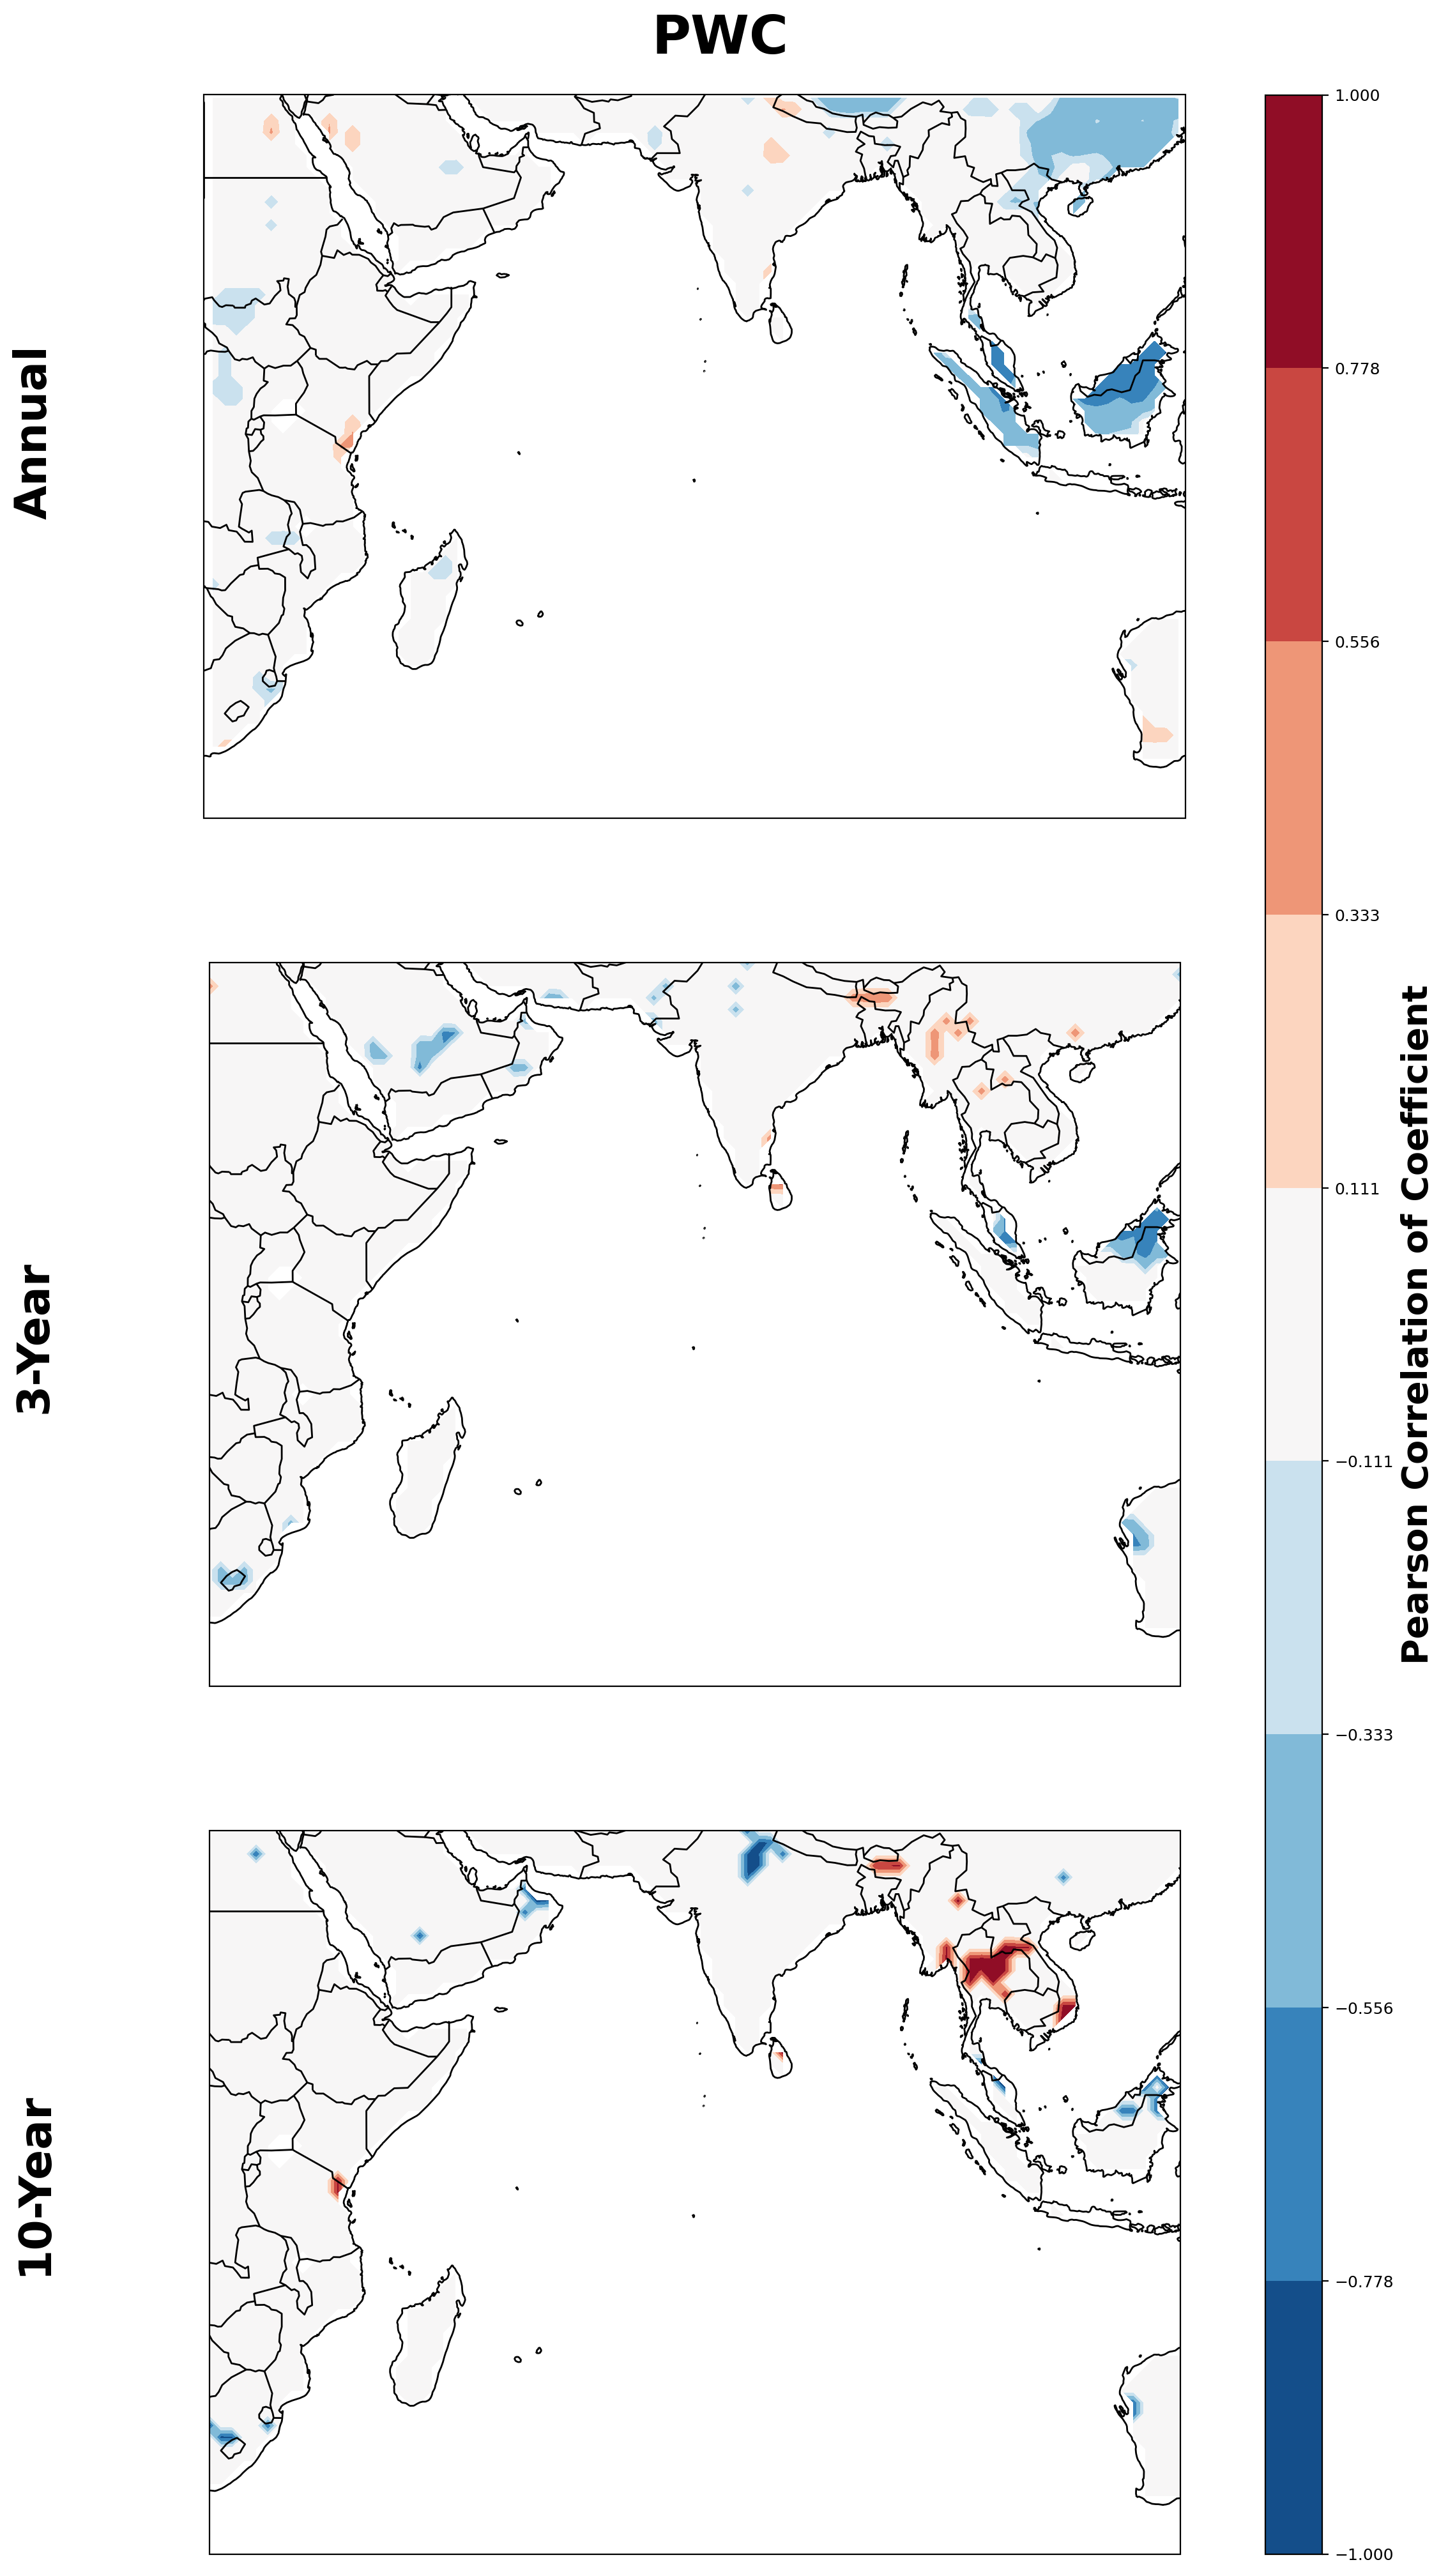

In [8]:
# Spatial Correlation with Colored Contours of d18O_P Amount-Weighted Annual Means and PWC
fig = plt.figure(figsize=(25, 25))
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 1], width_ratios=[1, 0.05], figure=fig)
gs.update(right=0.5, wspace=0, hspace=0.2)

levels = np.linspace(-1, 1, 10)

# PWC; Annual 
ax1 = fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=0))
cont1 = ax1.contourf(cor_mapPWC.Longitude, cor_mapPWC.Latitude, cor_mapPWC.values, levels=levels, extedn='both', cmap='RdBu_r')
ax1.set_extent(extent, ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax1.add_feature(cfeature.BORDERS)

# PWC; Amount-Weighted Ann Mean 3-Year
ax2 = fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree(central_longitude=0))
cont2 = ax2.contourf(cor_mapPWC3.Longitude, cor_mapPWC3.Latitude, cor_mapPWC3.values, levels=levels, extend='both',cmap='RdBu_r')
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax2.add_feature(cfeature.BORDERS)

# PWC; Amount-Weighted Ann Mean 10-Year
ax3 = fig.add_subplot(gs[2,0],projection=ccrs.PlateCarree(central_longitude=0))
cont3 = ax3.contourf(cor_mapPWC10.Longitude, cor_mapPWC10.Latitude, cor_mapPWC10.values, levels=levels, extend='both', cmap='RdBu_r')
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax3.add_feature(cfeature.BORDERS)

fig.text(0.29, 0.893, 'PWC', fontsize = 30, fontweight = 'bold', color = 'k')
fig.text(0.09, 0.75, 'Annual', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')
fig.text(0.09, 0.47, '3-Year', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')
fig.text(0.09, 0.2, '10-Year', fontsize = 25, fontweight = 'bold',rotation = 90, color = 'k')

# Colorbar
cbar_ax = fig.add_subplot(gs[:, 1])
cbar = plt.colorbar(cont1, cax=cbar_ax, orientation='vertical', extend='both', shrink=0.05)
cbar.ax.tick_params(labelsize=9)
cbar.set_label('Pearson Correlation of Coefficient', fontsize=20, fontweight='bold')

plt.tight_layout()
#plt.savefig('/Users/cpatrickfly/Library/CloudStorage/GoogleDrive-pcho@nd.edu/Shared drives/PhD Research/IWC Precipitation Isotopes/04_Outputs/240306_PWC_SpatialSupp_ERA5.pdf',bbox_inches='tight',dpi=600)

# Temporal Analysis

## Table S1; OND; OND Region and OND Metrics

In [7]:
region_means = pd.DataFrame(index=ond.index)

In [8]:
location = IOB.precip.isel(time=0) * 0 # Land-Sea Mask
ds = echam.where(location != 0) # Selecting only lands
weights = np.cos(np.deg2rad(ds.Latitude))

# Define latitude and longitude slices for different regions
lat_slices = [(0, 15), (-20, 0), (-10, 10)]
lon_slices = [(25, 60), (25, 60), (90, 120)]

region_means = pd.DataFrame(index=metricsMon.index)  # Create an empty DataFrame with the correct index; need to first use the MetricMon because the DS is in monthly format. 

region_names = ['Hrn18O', 'Knya18O', 'Indo18O'] # Three regions: Horn of Africa, Eastern Africa (around Kenya); Indonesia
lat_slices = [(0, 15), (-20, 0), (-10, 10)]
lon_slices = [(25, 60), (25, 60), (90, 120)]

# Loop to calculate regional averages and put outputs into DataFrame
for region_name, (lat_slice, lon_slice) in zip(region_names, zip(lat_slices, lon_slices)):
    region_data = echam.sel(Latitude=slice(*lat_slice), Longitude=slice(*lon_slice)).d18O_P.weighted(weights).mean(dim=('Latitude', 'Longitude')).to_dataframe()
    region_means[region_name] = region_data.values  # Assign values to the corresponding column

# OND Averages for each region
region_means['month']     = region_means.index.month
region_means              = region_means.loc[(region_means.index.month >= 10) & (region_means.index.month <= 12)].resample('Y').mean()
    
# Combine Yearly Metrics and OND Regions
dfO = pd.concat([ond, region_means], axis=1)
#dfO.index = dfO.Time
dfO = dfO.drop(columns=['month'])
dfO.to_csv(path2+'240814_PC_ONDMetrics_ONDRegion.csv'); #Save DF so we can use it for the Coherence Analyses

In [17]:
x = dfO[['u10','dSLPP']]# U10 = IWC; dSLPP = PWC
y = dfO[['Hrn18O','Knya18O','Indo18O']]

In [18]:
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y['Hrn18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.255   
Dependent Variable: Hrn18O           AIC:                128.1723
Date:               2024-11-11 10:44 BIC:                134.2483
No. Observations:   56               Log-Likelihood:     -61.086 
Df Model:           2                F-statistic:        10.42   
Df Residuals:       53               Prob (F-statistic): 0.000153
R-squared:          0.282            Scale:              0.54817 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -1.9883     0.1021   -19.4702   0.0000   -2.1931   -1.7835
u10       0.7996     0.1768     4.5240   0.0000    0.4451    1.1542
dSLPP    -0.2996     0.1538    -1.9486   0.0566   -0.6080    0.0088
-----------------------------------------------------------------
Omnibus:       

In [19]:
model = sm.OLS(y['Knya18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.320   
Dependent Variable: Knya18O          AIC:                130.1006
Date:               2024-11-11 10:44 BIC:                136.1766
No. Observations:   56               Log-Likelihood:     -62.050 
Df Model:           2                F-statistic:        13.96   
Df Residuals:       53               Prob (F-statistic): 1.35e-05
R-squared:          0.345            Scale:              0.56737 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -3.9865     0.1039   -38.3706   0.0000   -4.1948   -3.7781
u10       0.9311     0.1798     5.1779   0.0000    0.5704    1.2918
dSLPP    -0.3012     0.1564    -1.9251   0.0596   -0.6149    0.0126
-----------------------------------------------------------------
Omnibus:       

In [20]:
model = sm.OLS(y['Indo18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.441   
Dependent Variable: Indo18O          AIC:                170.3715
Date:               2024-11-11 10:44 BIC:                176.4476
No. Observations:   56               Log-Likelihood:     -82.186 
Df Model:           2                F-statistic:        22.68   
Df Residuals:       53               Prob (F-statistic): 7.65e-08
R-squared:          0.461            Scale:              1.1646  
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -6.6453     0.1488   -44.6449   0.0000   -6.9439   -6.3468
u10      -1.1462     0.2576    -4.4490   0.0000   -1.6629   -0.6295
dSLPP    -0.4106     0.2241    -1.8321   0.0726   -0.8602    0.0389
-----------------------------------------------------------------
Omnibus:       

## Table S1; October November, December; OND Region and Annual Metrics

In [13]:
df = metricsMon.copy()

location = IOB.precip.isel(time=0) * 0 # Land-Sea Mask
ds = echam.where(location != 0) # Selecting only lands
weights = np.cos(np.deg2rad(ds.Latitude))

# Define latitude and longitude slices for different regions
lat_slices = [(0, 15), (-20, 0), (-10, 10)]
lon_slices = [(25, 60), (25, 60), (90, 120)]

region_means = pd.DataFrame(index=df.index)  # Create an empty DataFrame with the correct index

region_names = ['Hrn18O', 'Knya18O', 'Indo18O'] # Three regions: Horn of Africa, Eastern Africa (around Kenya); Indonesia
lat_slices = [(0, 15), (-20, 0), (-10, 10)]
lon_slices = [(25, 60), (25, 60), (90, 120)]

# Loop to calculate regional averages and put outputs into DataFrame
for region_name, (lat_slice, lon_slice) in zip(region_names, zip(lat_slices, lon_slices)):
    region_data = echam.sel(Latitude=slice(*lat_slice), Longitude=slice(*lon_slice)).d18O_P.weighted(weights).mean(dim=('Latitude', 'Longitude')).to_dataframe()
    region_means[region_name] = region_data.values  # Assign values to the corresponding column

# OND Averages for each region
region_means['month']     = region_means.index.month
region_means              = region_means.loc[(region_means.index.month >= 10) & (region_means.index.month <= 12)].resample('Y').mean()
    
# Combine Yearly Metrics and OND Regions
df = df.resample('y').mean()
dfO = pd.concat([df, region_means], axis=1)
#dfO.index = dfO.Time
dfO = dfO.drop(columns=['month'])
#dfO.to_csv(path2+'240304_PC_MetricsOND_Region.csv'); #Save DF so we can use it for the Coherence Analyses

In [13]:
x = dfO[['u10','dSLPP']]# U10 = IWC; dSLPP = PWC
y = dfO[['Hrn18O','Knya18O','Indo18O']]

In [14]:
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y['Hrn18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.391   
Dependent Variable: Hrn18O           AIC:                116.9294
Date:               2024-08-14 10:13 BIC:                123.0054
No. Observations:   56               Log-Likelihood:     -55.465 
Df Model:           2                F-statistic:        18.62   
Df Residuals:       53               Prob (F-statistic): 7.49e-07
R-squared:          0.413            Scale:              0.44846 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -1.9676     0.0917   -21.4489   0.0000   -2.1516   -1.7836
u10       0.4348     0.0815     5.3380   0.0000    0.2714    0.5982
dSLPP    -0.1607     0.1097    -1.4649   0.1489   -0.3807    0.0593
-----------------------------------------------------------------
Omnibus:       

In [15]:
model = sm.OLS(y['Knya18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.478   
Dependent Variable: Knya18O          AIC:                115.3186
Date:               2024-08-14 10:13 BIC:                121.3946
No. Observations:   56               Log-Likelihood:     -54.659 
Df Model:           2                F-statistic:        26.18   
Df Residuals:       53               Prob (F-statistic): 1.24e-08
R-squared:          0.497            Scale:              0.43574 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -3.9607     0.0904   -43.8011   0.0000   -4.1421   -3.7793
u10       0.4975     0.0803     6.1966   0.0000    0.3365    0.6586
dSLPP    -0.1598     0.1081    -1.4784   0.1452   -0.3767    0.0570
-----------------------------------------------------------------
Omnibus:       

In [16]:
model = sm.OLS(y['Indo18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.552   
Dependent Variable: Indo18O          AIC:                158.0062
Date:               2024-08-14 10:13 BIC:                164.0823
No. Observations:   56               Log-Likelihood:     -76.003 
Df Model:           2                F-statistic:        34.83   
Df Residuals:       53               Prob (F-statistic): 2.20e-10
R-squared:          0.568            Scale:              0.93387 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -6.7269     0.1324   -50.8164   0.0000   -6.9925   -6.4614
u10      -0.4253     0.1175    -3.6180   0.0007   -0.6610   -0.1895
dSLPP    -0.4826     0.1583    -3.0490   0.0036   -0.8001   -0.1651
-----------------------------------------------------------------
Omnibus:       

## Table S1; Full Calendar Year (Amount-Weighted Annual Means)

In [21]:
ann     = amount_weighted_ann_mean(IOB,'precip',['d18O_P'])

# Loop to calculate regional averages and put outputs into DataFrame
for region_name, (lat_slice, lon_slice) in zip(region_names, zip(lat_slices, lon_slices)):
    region_data = ann.sel(Latitude=slice(*lat_slice), Longitude=slice(*lon_slice)).d18O_P.weighted(weights).mean(dim=('Latitude', 'Longitude')).to_dataframe()
    region_means[region_name] = region_data.values  # Assign values to the corresponding column
    
# Combine Yearly Metrics and Amount-Weighted Annual Mean Regions
dfA = pd.concat([df, region_means], axis=1)
dfA = dfA.drop(columns=['month'])
#dfA.to_csv(path2+'240305_PC_MetricsAnn_Regions.csv') we will use this for Coherence Analysis

In [22]:
x = dfA[['u10','dSLPP']]
y = dfA[['Hrn18O','Knya18O','Indo18O']]

x = sm.add_constant(x) # adding a constant

In [23]:
model = sm.OLS(y['Hrn18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.142  
Dependent Variable: Hrn18O           AIC:                92.8262
Date:               2024-11-11 10:45 BIC:                98.9022
No. Observations:   56               Log-Likelihood:     -43.413
Df Model:           2                F-statistic:        5.547  
Df Residuals:       53               Prob (F-statistic): 0.00650
R-squared:          0.173            Scale:              0.29161
------------------------------------------------------------------
         Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
------------------------------------------------------------------
const   -2.0324     0.0745   -27.2868   0.0000   -2.1818   -1.8830
u10      0.3882     0.1289     3.0113   0.0040    0.1296    0.6468
dSLPP   -0.3173     0.1122    -2.8296   0.0066   -0.5423   -0.0924
----------------------------------------------------------------
Omnibus:              0.593   

In [24]:
model = sm.OLS(y['Knya18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.139  
Dependent Variable: Knya18O          AIC:                39.3947
Date:               2024-11-11 10:45 BIC:                45.4708
No. Observations:   56               Log-Likelihood:     -16.697
Df Model:           2                F-statistic:        5.451  
Df Residuals:       53               Prob (F-statistic): 0.00703
R-squared:          0.171            Scale:              0.11231
------------------------------------------------------------------
         Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
------------------------------------------------------------------
const   -2.4310     0.0462   -52.5917   0.0000   -2.5237   -2.3383
u10      0.2606     0.0800     3.2574   0.0020    0.1001    0.4211
dSLPP   -0.1546     0.0696    -2.2216   0.0306   -0.2942   -0.0150
----------------------------------------------------------------
Omnibus:              0.688   

In [25]:
model = sm.OLS(y['Indo18O'], x).fit()
predictions = model.predict(x) 
 
print_model = model.summary2()
print(print_model)

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.423   
Dependent Variable: Indo18O          AIC:                -84.3048
Date:               2024-11-11 10:45 BIC:                -78.2288
No. Observations:   56               Log-Likelihood:     45.152  
Df Model:           2                F-statistic:        21.19   
Df Residuals:       53               Prob (F-statistic): 1.72e-07
R-squared:          0.444            Scale:              0.012334
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const    -1.4262     0.0153   -93.1041   0.0000   -1.4569   -1.3955
u10      -0.0291     0.0265    -1.0984   0.2770   -0.0823    0.0241
dSLPP    -0.1106     0.0231    -4.7937   0.0000   -0.1568   -0.0643
-----------------------------------------------------------------
Omnibus:       